Epoch [1/50]
Loss: 2.6756, Classification Loss: 1.1838, Domain Loss: 0.0000, Diversity Loss: 1.4918
Random weights generated for the hidden layer.
Hidden layer output calculated.
Epoch [2/50]
Loss: 2.4782, Classification Loss: 0.8874, Domain Loss: 0.0000, Diversity Loss: 1.5908
Random weights generated for the hidden layer.
Hidden layer output calculated.
Epoch [3/50]
Loss: 2.4418, Classification Loss: 0.8479, Domain Loss: 0.0000, Diversity Loss: 1.5939
Random weights generated for the hidden layer.
Hidden layer output calculated.
Epoch [4/50]
Loss: 2.4356, Classification Loss: 0.8518, Domain Loss: 0.0000, Diversity Loss: 1.5838
Random weights generated for the hidden layer.
Hidden layer output calculated.
Epoch [5/50]
Loss: 2.4002, Classification Loss: 0.8136, Domain Loss: 0.0000, Diversity Loss: 1.5867
Random weights generated for the hidden layer.
Hidden layer output calculated.
Epoch [6/50]
Loss: 2.4028, Classification Loss: 0.8013, Domain Loss: 0.0000, Diversity Loss: 1.6015
Rando

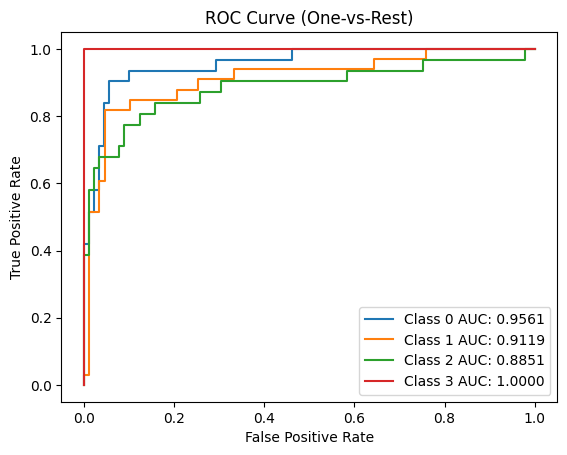

Image: COVID-111.png, Predicted Class: 0
Image: COVID-112.png, Predicted Class: 0
Image: COVID-113.png, Predicted Class: 0
Image: COVID-114.png, Predicted Class: 0
Image: COVID-115.png, Predicted Class: 0
Image: Lung_Opacity-21.png, Predicted Class: 1
Image: Lung_Opacity-22.png, Predicted Class: 1
Image: Lung_Opacity-23.png, Predicted Class: 1
Image: Lung_Opacity-24.png, Predicted Class: 1
Image: Lung_Opacity-25.png, Predicted Class: 1
Image: Normal-341.png, Predicted Class: 2
Image: Normal-342.png, Predicted Class: 2
Image: Normal-343.png, Predicted Class: 2
Image: Normal-344.png, Predicted Class: 2
Image: Normal-345.png, Predicted Class: 2
Image: Viral Pneumonia-351.png, Predicted Class: 3
Image: Viral Pneumonia-352.png, Predicted Class: 3
Image: Viral Pneumonia-353.png, Predicted Class: 3
Image: Viral Pneumonia-354.png, Predicted Class: 3
Image: Viral Pneumonia-355.png, Predicted Class: 2


In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Set the device to CPU
device = torch.device('cpu')

# Load and preprocess the dataset with added data augmentation for improved generalization
def load_data(data_dir):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Data augmentation: horizontal flip
        transforms.RandomVerticalFlip(),  # Data augmentation: vertical flip
        transforms.RandomRotation(20),  # Data augmentation: random rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Data augmentation: color jitter
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    return dataset

# Load datasets
data_dir = 'C:/Users/HP/Desktop/SAMPLE'  # Change this to your dataset path
dataset = load_data(data_dir)

# Split dataset into training and validation (80/20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define ResNet Feature Extractor with fine-tuning enabled
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')  # Using the latest weights argument
        # Fine-tune all layers instead of freezing
        for param in self.resnet.parameters():
            param.requires_grad = True
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer

    def forward(self, x):
        return self.resnet(x)

# Define ELM Classifier with increased hidden neurons and batch normalization for stability
class ELMClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ELMClassifier, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_layer = nn.Linear(input_size, 2000)  # Increased number of neurons in hidden layer
        self.bn = nn.BatchNorm1d(2000)  # Added batch normalization to improve generalization
        self.output_layer = nn.Linear(2000, num_classes)  # Output layer
        self.hidden_weights = torch.randn(2000, input_size)  # Randomly initialized hidden layer weights
        self.output_weights = None  # To be computed during training

    def forward(self, x):
        h = F.relu(self.bn(self.hidden_layer(x)))  # Apply ReLU and batch normalization on hidden layer
        return self.output_layer(h)

    def compute_output_weights(self, h, labels):
        labels = labels.float()  # Ensure labels are converted to Float type
        self.output_weights = torch.linalg.pinv(h) @ labels  # Compute the output weights

# Loss function with L2 regularization (weight decay) and combined losses
def compute_losses(source_features, target_features, labels, model):
    domain_loss = F.mse_loss(source_features, target_features)  # Domain loss (MSE)
    classification_loss = F.cross_entropy(model(source_features), labels)  # Classification loss
    diversity_loss = -torch.mean(torch.log_softmax(model(source_features), dim=1))  # Diversity loss
    total_loss = domain_loss + classification_loss + diversity_loss  # Total combined loss
    return total_loss, classification_loss, domain_loss, diversity_loss

# Training function with additional steps for generating random weights and updating weights
def train(model, feature_extractor, train_loader, optimizer, num_epochs=50):
    model.train()
    feature_extractor.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_classification_loss = 0.0
        total_domain_loss = 0.0
        total_diversity_loss = 0.0
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Step 3: Extract features using ResNet
            features = feature_extractor(images)

            # Step 4-6: Compute losses
            total_loss, classification_loss, domain_loss, diversity_loss = compute_losses(features, features, labels, model)

            # Step 7: Backward propagation and optimization
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            total_classification_loss += classification_loss.item()
            total_domain_loss += domain_loss.item()
            total_diversity_loss += diversity_loss.item()

        print(f"Loss: {running_loss / len(train_loader):.4f}, "
              f"Classification Loss: {total_classification_loss / len(train_loader):.4f}, "
              f"Domain Loss: {total_domain_loss / len(train_loader):.4f}, "
              f"Diversity Loss: {total_diversity_loss / len(train_loader):.4f}")

        # Step 9: Generate random weights for the hidden layer
        model.hidden_weights = torch.randn(2000, 512)  # Adjusted for hidden layer size
        print("Random weights generated for the hidden layer.")

        # Step 10: Compute hidden layer output matrix
        hidden_output = F.relu(model.hidden_layer(features))
        print("Hidden layer output calculated.")

        # Step 11: Calculate output weights
        model.compute_output_weights(hidden_output, labels)

# Validation function with metrics (precision, recall, F1, and AUC) and ROC Curve plotting
def validate(model1, model2, feature_extractor, val_loader):
    model1.eval()
    model2.eval()
    feature_extractor.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Step 12: Obtain feature map of test data
            features = feature_extractor(images)

            # Step 13: Calculate output from both ELM classifiers
            outputs1 = model1(features)
            outputs2 = model2(features)

            # Step 14: Fuse predictions from Y1 and Y2
            final_output = (outputs1 + outputs2) / 2
            probabilities = torch.softmax(final_output, dim=1)  # Softmax to get probabilities
            _, predicted = torch.max(final_output.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')

    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # ROC Curve plotting for each class (one-vs-rest)
    for i in range(probabilities.shape[1]):
        fpr, tpr, _ = roc_curve([1 if label == i else 0 for label in all_labels], 
                                [prob[i] for prob in all_probabilities])
        plt.plot(fpr, tpr, label=f"Class {i} AUC: {roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probabilities]):.4f}")
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend(loc='best')
    plt.show()

# Load and preprocess images for prediction
def load_images_from_folder(folder_path):
    images = []
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path).convert('RGB')
            image = transform(image)
            images.append((filename, image))
    return images

# Predict images in a given folder
def predict_images(folder_path, feature_extractor, elm_classifier1, elm_classifier2):
    images = load_images_from_folder(folder_path)
    
    feature_extractor.eval().to(device)
    elm_classifier1.eval().to(device)
    elm_classifier2.eval().to(device)
    
    for filename, image in images:
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            features = feature_extractor(image)
        
        outputs1 = elm_classifier1(features)
        outputs2 = elm_classifier2(features)
        
        final_output = (outputs1 + outputs2) / 2
        _, predicted = torch.max(final_output.data, 1)
        
        print(f"Image: {filename}, Predicted Class: {predicted.item()}")

# Example usage
if __name__ == "__main__":
    feature_extractor = FeatureExtractor().to(device)
    
    # Create two ELM classifiers
    elm_classifier1 = ELMClassifier(input_size=512, num_classes=4).to(device)
    elm_classifier2 = ELMClassifier(input_size=512, num_classes=4).to(device)

    # Optimizer with L2 regularization
    optimizer = optim.Adam(list(elm_classifier1.parameters()) + list(elm_classifier2.parameters()), lr=0.0001, weight_decay=1e-5)

    # Train the model with 50 epochs
    train(elm_classifier1, feature_extractor, train_loader, optimizer, num_epochs=50)

    # Validate the model
    validate(elm_classifier1, elm_classifier2, feature_extractor, val_loader)

    # Predict images in a folder
    folder_path = input("Enter the folder path containing images for prediction: ")
    if not os.path.exists(folder_path):
        print(f"The folder path {folder_path} does not exist.")
    else:
        predict_images(folder_path, feature_extractor, elm_classifier1, elm_classifier2)
